In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.datasets import mnist, fashion_mnist
from keras.layers import Dense,InputLayer, Flatten, Convolution2D, MaxPooling2D, Reshape

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(60000, 28, 28)

In [4]:
X_train.dtype

dtype('uint8')

In [5]:
np.sum(np.isnan(X_train),axis=None)

np.int64(0)

In [7]:
print('max =',np.max(X_train,axis=None))
print('min =',np.min(X_train,axis=None))
print('mean =',np.mean(X_train,axis=None))
print('std =',np.std(X_train,axis=None))

max = 255
min = 0
mean = 72.94035223214286
std = 90.02118235130526


In [8]:
y_train.shape

(60000,)

In [17]:
y_series = pd.Series(y_train)
y_series.sample(10)

36147    1
17377    4
58804    6
26559    8
22063    2
49307    6
4229     8
11221    1
1117     8
27611    0
dtype: uint8

In [18]:
print(y_series.head(5))
print(y_series.tail(5))

0    9
1    0
2    0
3    3
4    0
dtype: uint8
59995    5
59996    1
59997    3
59998    0
59999    5
dtype: uint8


In [15]:
print('max =',np.max(y_train,axis=None))
print('min =',np.min(y_train,axis=None))

max = 9
min = 0


y_train
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

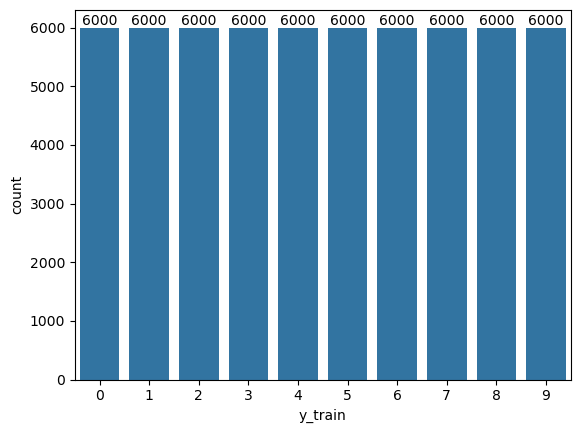

In [20]:
y_series = pd.Series(data=y_train, name='y_train')
GB_y = y_series.value_counts().sort_index()
display(GB_y)

ax = sns.barplot(x=GB_y.index,y=GB_y)
for c in ax.containers:
    ax.bar_label(c)
plt.show()

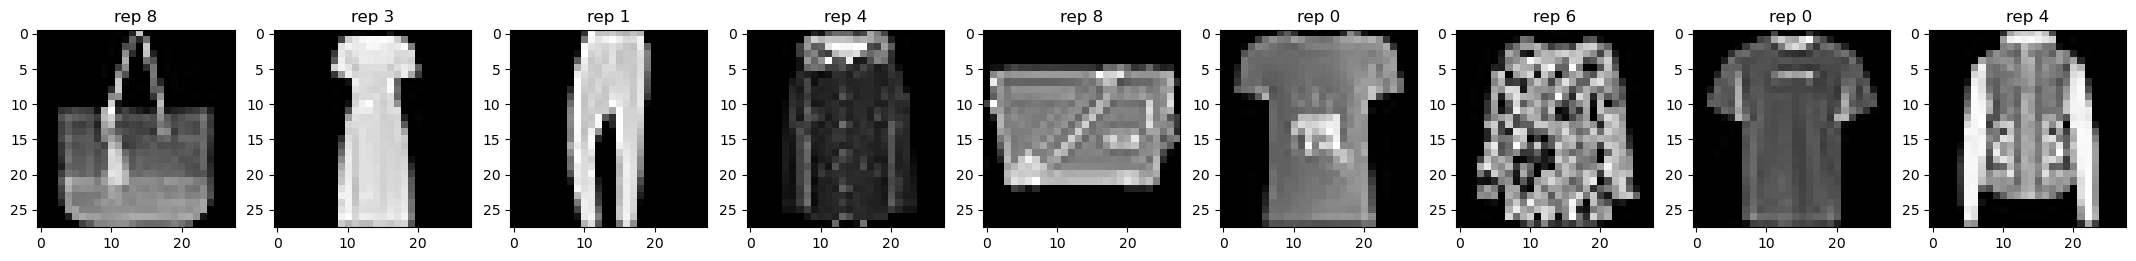

In [36]:
N = 10
lst_rdm = np.unique(np.random.randint(1,200,N))

plt.figure(figsize=(3*N,5))
for n,idx in enumerate(lst_rdm):
    plt.subplot(1,N,n+1)
    plt.imshow(X_train[idx], cmap='grey')
    plt.title(f'rep {y_train[idx]}')

plt.show()

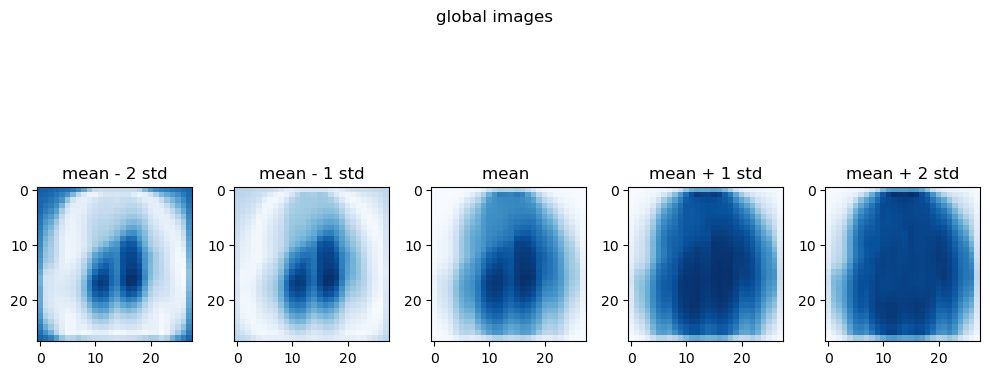

In [19]:
glob_avg_img = np.mean(X_train,axis=0) ## image moyenne
glob_std_img = np.std(X_train,axis=0) ## std d'image

plt.figure(figsize=(10,5))
plt.subplot(1,5,1)
plt.imshow(glob_avg_img-2*glob_std_img,cmap='Blues')
plt.title(f'mean - 2 std')

plt.subplot(1,5,2)
plt.imshow(glob_avg_img-1*glob_std_img,cmap='Blues')
plt.title(f'mean - 1 std')

plt.subplot(1,5,3)
plt.imshow(glob_avg_img ,cmap='Blues')
plt.title(f'mean ')

plt.subplot(1,5,4)
plt.imshow(glob_avg_img+1*glob_std_img,cmap='Blues')
plt.title(f'mean + 1 std')

plt.subplot(1,5,5)
plt.imshow(glob_avg_img+2*glob_std_img,cmap='Blues')
plt.title(f'mean + 2 std')

plt.suptitle('global images')
plt.tight_layout()
plt.show()

### Preprocessing

In [21]:
X_train = X_train/np.max(X_train,axis=None) ## diviser par 255
X_test = X_test/np.max(X_test,axis=None)

### Preprocessing pour le DNN
flattened_X_train = X_train.reshape(60_000,28*28)
flattened_X_test = X_test.reshape(-1,28*28)

### Models

In [29]:
N_CLASSES = 10           ## number of classes to predict
INPUT_SHAPE = (28*28,)   ## shape of X_train
OUTPUT_ACTIVATION_FUNCTION = 'softmax' ## softmax because multiple categories
LOSS = 'sparse_categorical_crossentropy'

def simple_dnn_model():    
    simple = tf.keras.models.Sequential([
        InputLayer(shape=INPUT_SHAPE)

        ### hidden layers 
        , Dense(128, activation='relu')

        ### output layer
        , Dense(units=N_CLASSES
               ,activation= OUTPUT_ACTIVATION_FUNCTION
               ,name ='my_output_layer'
            )
    ])

    ### "compile"/compress model = MANDATORY
    simple.compile(
        optimizer='adam', #'adam', ## use this by default
        loss=LOSS, ## binary classification
        metrics=['accuracy'] ## additional metric
    )
    return simple

def cnn_model():
    ACTIVATION = 'relu'
    KERNEL_SIZE = 2
    PADDING = 'same'
    cnn = tf.keras.models.Sequential([
        InputLayer(shape=INPUT_SHAPE),
        Reshape((28, 28, 1)),

        Convolution2D(filters=16, kernel_size=KERNEL_SIZE, padding=PADDING, activation=ACTIVATION),
        Convolution2D(filters=16, kernel_size=KERNEL_SIZE, padding=PADDING, activation=ACTIVATION),

        MaxPooling2D(2),

        Convolution2D(filters=32, kernel_size=KERNEL_SIZE, padding=PADDING, activation=ACTIVATION),
        Convolution2D(filters=32, kernel_size=KERNEL_SIZE, padding=PADDING, activation=ACTIVATION),

        MaxPooling2D(2),

        Convolution2D(filters=32, kernel_size=KERNEL_SIZE, padding=PADDING, activation=ACTIVATION),
        Convolution2D(filters=32, kernel_size=KERNEL_SIZE, padding=PADDING, activation=ACTIVATION),

        MaxPooling2D(2),

        Flatten(),

        Dense(75, activation=ACTIVATION),
        Dense(50, activation=ACTIVATION),

        Dense(N_CLASSES, activation=OUTPUT_ACTIVATION_FUNCTION)
    ])

    cnn.compile(optimizer=keras.optimizers.Adam(),
                loss=LOSS,
                metrics=['accuracy'])
    return cnn

def plot_lc(history: dict, metrics: list = ['loss', 'accuracy']) -> None:
    plt.figure(figsize=(20, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.title(f'Learning curve for {metric}\n')
        plt.plot(history[metric], label='train')
        plt.plot(history[f'val_{metric}'], label='val')
        plt.xlabel('epochs')
        plt.ylabel(metric)
        plt.legend()
        if metric == 'accuracy':
            plt.ylim(0,1.1)
    plt.show()


def plot_cm(y_true: np.array, y_pred: np.array) -> None:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 8))
    plt.title('Confusion Matrix\n')
    sns.heatmap(cm, cmap='vlag', annot=True, fmt='d', cbar=False)
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    plt.show()


def plot_cm_display(y_true: np.array, y_pred: np.array) -> None:
    cm = confusion_matrix(y_true, y_pred)
    
    #plt.figure(figsize=(20, 8))
    #plt.title('Confusion Matrix\n')
    CM = ConfusionMatrixDisplay(cm)
    CM.plot()
    #sns.heatmap(cm, cmap='vlag', annot=True, fmt='d', cbar=False)
    #plt.xlabel('y_pred')
    #plt.ylabel('y_true')
    plt.show()

Train DNN model

In [23]:
dnn = simple_dnn_model()

dnn_h = dnn.fit(
    flattened_X_train,
    y_train,
    batch_size=16,
    validation_split=0.15,
    epochs=20
)

Epoch 1/20
3188/3188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8249 - loss: 0.4941 - val_accuracy: 0.8548 - val_loss: 0.4139
Epoch 2/20
3188/3188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8631 - loss: 0.3751 - val_accuracy: 0.8684 - val_loss: 0.3660
Epoch 3/20
3188/3188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8772 - loss: 0.3371 - val_accuracy: 0.8711 - val_loss: 0.3467
Epoch 4/20
3188/3188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8836 - loss: 0.3155 - val_accuracy: 0.8772 - val_loss: 0.3400
Epoch 5/20
3188/3188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8920 - loss: 0.2955 - val_accuracy: 0.8803 - val_loss: 0.3427
Epoch 6/20
3188/3188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8963 - loss: 0.2827 - val_accuracy: 0.8822 - val_loss: 0.3329
Epoch 7/20
3188/3188 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8985 - loss: 0.2694 - val_accuracy: 0.8872 - val_loss: 0.3266
Epoch 8/20
3188/3188 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9022 - loss: 0.2

In [24]:
dnn_h.history

{'accuracy': [0.8248823285102844,
  0.8631176352500916,
  0.8771568536758423,
  0.883647084236145,
  0.8920392394065857,
  0.896294116973877,
  0.8984509706497192,
  0.9022156596183777,
  0.9061176180839539,
  0.9094117879867554,
  0.9122745394706726,
  0.9148627519607544,
  0.9184901714324951,
  0.9213921427726746,
  0.9215098023414612,
  0.9236274361610413,
  0.9279608130455017,
  0.9297842979431152,
  0.9310196042060852,
  0.9319411516189575],
 'loss': [0.4940524399280548,
  0.3751186728477478,
  0.337138831615448,
  0.31551218032836914,
  0.2954985201358795,
  0.2826770544052124,
  0.26936042308807373,
  0.25985071063041687,
  0.2497902810573578,
  0.23995953798294067,
  0.23180606961250305,
  0.2249675840139389,
  0.21698762476444244,
  0.21059051156044006,
  0.20487262308597565,
  0.19957751035690308,
  0.1929798126220703,
  0.18922249972820282,
  0.18275350332260132,
  0.17920668423175812],
 'val_accuracy': [0.8547777533531189,
  0.8684444427490234,
  0.8711110949516296,
  0.877

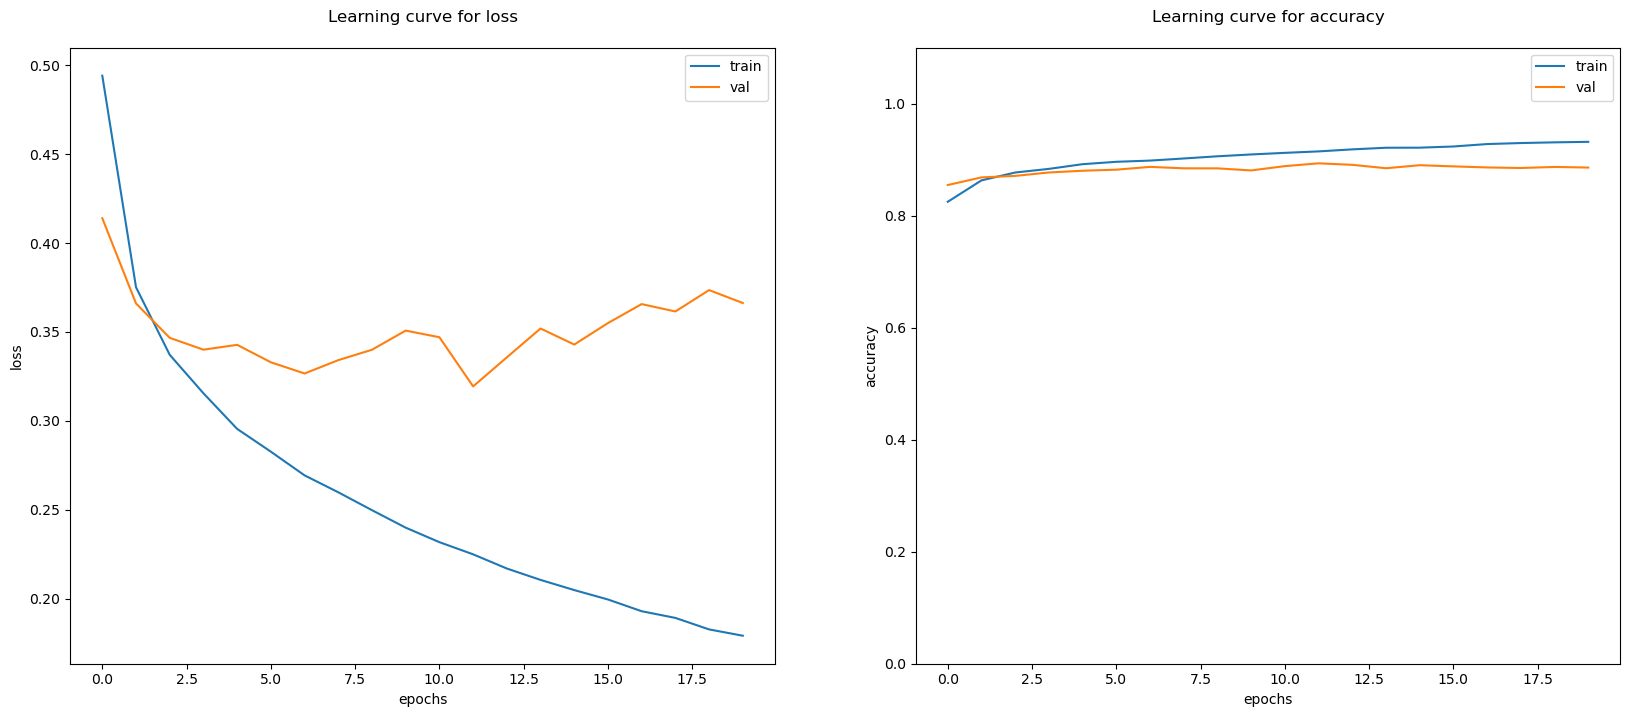

In [27]:
plot_lc(history=dnn_h.history)

Train CNN model

In [30]:
cnn = cnn_model()

cnn_h = cnn.fit(
    flattened_X_train, 
    y_train, 
    epochs=15, 
    validation_split=.2, 
    batch_size=500
)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.5986 - loss: 1.1215 - val_accuracy: 0.7579 - val_loss: 0.6115
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7941 - loss: 0.5530 - val_accuracy: 0.8080 - val_loss: 0.5144
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8263 - loss: 0.4732 - val_accuracy: 0.8394 - val_loss: 0.4359
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8470 - loss: 0.4186 - val_accuracy: 0.8486 - val_loss: 0.4140
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8546 - loss: 0.3980 - val_accuracy: 0.8614 - val_loss: 0.3828
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8689 - loss: 0.3623 - val_accuracy: 0.8595 - val_loss: 0.3768
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8766 - loss: 0.3391 - val_accuracy: 0.8767 - val_loss: 0.3406
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.8818 - loss: 0.3246 - val_accuracy: 0.8798 - 

In [31]:
cnn_h.history

{'accuracy': [0.598562479019165,
  0.7941458225250244,
  0.8263124823570251,
  0.8470208048820496,
  0.8545833230018616,
  0.8689166903495789,
  0.8766458630561829,
  0.8818125128746033,
  0.8867916464805603,
  0.8901041746139526,
  0.8932499885559082,
  0.8965208530426025,
  0.9003333449363708,
  0.9023541808128357,
  0.9044791460037231],
 'loss': [1.1214845180511475,
  0.5529520511627197,
  0.473219633102417,
  0.41862502694129944,
  0.3979817032814026,
  0.3622700273990631,
  0.339089572429657,
  0.32458212971687317,
  0.30986684560775757,
  0.30037054419517517,
  0.2966710329055786,
  0.2823246121406555,
  0.2740359902381897,
  0.26926273107528687,
  0.26427194476127625],
 'val_accuracy': [0.7579166889190674,
  0.8080000281333923,
  0.8394166827201843,
  0.8485833406448364,
  0.8614166378974915,
  0.859499990940094,
  0.8767499923706055,
  0.8798333406448364,
  0.8842499852180481,
  0.8854166865348816,
  0.8845000267028809,
  0.890250027179718,
  0.8955000042915344,
  0.89674997329

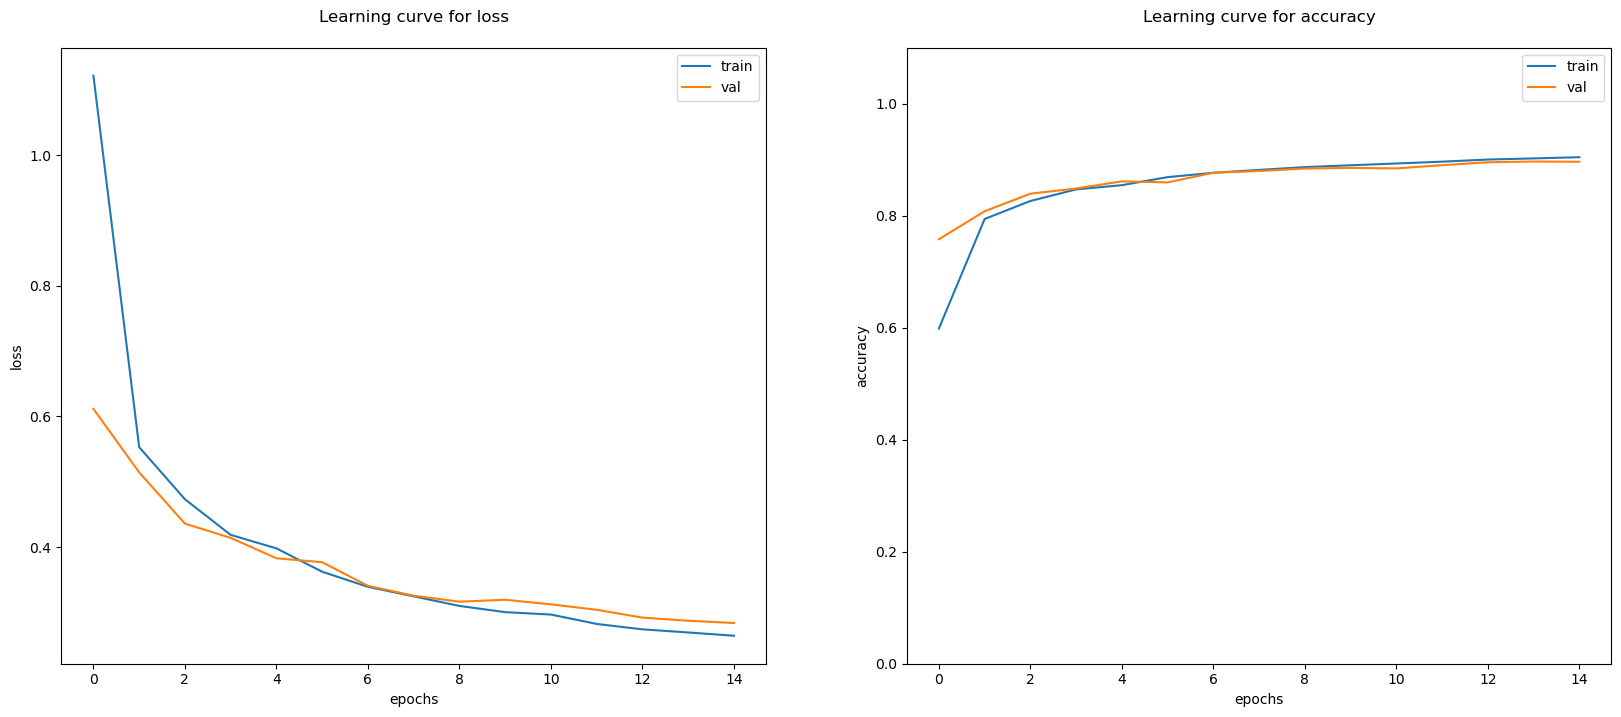

In [32]:
plot_lc(history=cnn_h.history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


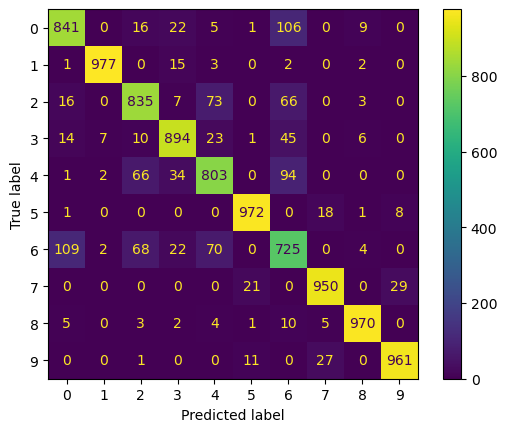

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.83      0.84      1000
           3       0.90      0.89      0.90      1000
           4       0.82      0.80      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.69      0.72      0.71      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [34]:
y_pred_range = cnn.predict(flattened_X_test)
y_pred = np.argmax(y_pred_range,axis=1)

plot_cm_display(y_true=y_test,y_pred=y_pred)
print(classification_report(y_true=y_test,y_pred=y_pred))

In [37]:
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 16)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75)             │        21,675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,709 (487.15 KB)

 Trainable params: 41,569 (162.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83,140 (324.77 KB)

In [38]:
for i, layer in enumerate(cnn.layers):
    print(i, layer.name)

0 reshape_1
1 conv2d_6
2 conv2d_7
3 max_pooling2d_3
4 conv2d_8
5 conv2d_9
6 max_pooling2d_4
7 conv2d_10
8 conv2d_11
9 max_pooling2d_5
10 flatten_1
11 dense_4
12 dense_5
13 dense_6
